In [1]:
pwd

'e:\\two_stage_model\\data_processing\\Speed_Processing'

In [2]:
cd ..

e:\two_stage_model\data_processing


In [3]:

import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import pickle
import math

from datetime import datetime as dt
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.stats import hmean

In [4]:
# Hyper-parameters during Data Processing 

# Time
start_date = dt(2022, 2, 1)
end_date = dt(2024, 1, 31)
start_min = 330 # 05:30:00 
end_min = 1260 # 21:00:00
country_name = 'Cranberry'
model_path = 'E:/two_stage_model'

analysis_time_interval = 5 # in min
para_na_rate_spd_quantile_threshold_tmc_all = 1
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates

## Part 1. Read Files

### 1.1 TMC Data
- Speed 
    - All (1431 TMC segments with geo-info and upstream segments, for TSMO)
    - PV (584 TMC segments with geo-info and upstream segments, for TSMO)
    - Truck (583 TMC segments with geo-info and upstream segments, for TSMO)

In [5]:
# TMC Speed Data 
# (1) All
df_spd_tmc_1min_all = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_1min_all.pkl", "rb"))  
df_spd_tmc_5min_all = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_5min_all.pkl", "rb"))  
# (2) Personal Vehicles
df_spd_tmc_5min_pv = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_5min_pv.pkl", "rb"))  
# (3) Trucks
df_spd_tmc_5min_truck = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_5min_truck.pkl", "rb")) 

In [6]:
df_spd_tmc_1min_all

tmc_code,104+04435,104+04436,104+04437,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,...,104P51588,104P51590,104P51594,104P51602,104P51608,104P51618,104P51620,104P51754,104P51833,104P51835
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-01 05:30:00,68.0,63.0,63.0,63.0,67.0,63.0,67.0,70.0,69.0,71.0,...,32.0,58.0,47.0,45.0,40.0,40.0,30.0,44.0,44.0,42.0
2022-02-01 05:31:00,67.0,63.0,56.0,63.0,67.0,63.0,68.0,69.0,69.0,64.0,...,32.0,57.0,47.0,45.0,40.0,40.0,30.0,44.0,44.0,42.0
2022-02-01 05:32:00,66.0,62.0,56.0,63.0,66.0,64.0,67.0,70.0,69.0,64.0,...,32.0,57.0,47.0,45.0,40.0,40.0,30.0,44.0,44.0,40.0
2022-02-01 05:33:00,66.0,62.0,55.0,63.0,65.0,64.0,67.0,70.0,69.0,64.0,...,32.0,57.0,47.0,45.0,43.0,40.0,32.0,37.0,44.0,40.0
2022-02-01 05:34:00,66.0,62.0,55.0,63.0,65.0,64.0,67.0,70.0,68.0,64.0,...,32.0,57.0,47.0,46.0,43.0,40.0,32.0,31.0,44.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:55:00,65.0,54.0,52.0,62.0,62.0,65.0,70.0,71.0,70.0,66.0,...,34.0,40.0,48.0,41.0,36.0,46.0,34.0,37.0,44.0,47.0
2024-01-31 20:56:00,65.0,53.0,52.0,62.0,62.0,65.0,68.0,71.0,70.0,66.0,...,34.0,41.0,48.0,41.0,36.0,46.0,34.0,37.0,44.0,47.0
2024-01-31 20:57:00,65.0,61.0,62.0,61.0,61.0,64.0,68.0,71.0,72.0,65.0,...,34.0,41.0,48.0,41.0,36.0,46.0,34.0,37.0,44.0,47.0


### 1.2 Geo Data
- Shapefile (used for visualization)

In [7]:
# Shape
gdf_tmc = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc = gdf_tmc.rename(columns={"tmc":"id_tmc", "miles":"miles_tmc"})

In [8]:
# neighbour info
dict_prev_tmc = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_dict_prev_tmc.pkl", "rb"))

In [9]:
gdf_tmc # for TMSO network, 1591 links totally

,fid,id_tmc,miles_tmc,direction,type_x,type_y,road_order,roadname,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude,geometry
0,1,104-08640,0.472527,SOUTHBOUND,P3.2,Feature,1.0,W CARSON ST,PA-837,ALLEGHENY,PA,15219,40.44278,-80.02468,40.43960,-80.01675,"MULTILINESTRING ((-80.02468 40.44278, -80.0244..."
1,2,104P50769,0.018409,WESTBOUND,P1.11,Feature,1.0,RIDGE AVE,NaN,ALLEGHENY,PA,15233,40.44938,-80.02277,40.44950,-80.02308,"MULTILINESTRING ((-80.02277 40.44938, -80.0228..."
2,3,104-04517,0.028464,WESTBOUND,P1.3,Feature,1.0,I-376 W,I-376,ALLEGHENY,PA,15219,40.43832,-80.01230,40.43808,-80.01274,"MULTILINESTRING ((-80.01230 40.43832, -80.0125..."
3,4,104-04551,0.143105,SOUTHBOUND,P1.3,Feature,1.0,NaN,I-579,ALLEGHENY,PA,15212,40.45402,-79.99763,40.45224,-79.99626,"MULTILINESTRING ((-79.99763 40.45402, -79.9975..."
4,5,104-04555,0.127161,SOUTHBOUND,P1.3,Feature,1.0,I-579,I-579,ALLEGHENY,PA,15212,40.45407,-79.99725,40.45242,-79.99620,"MULTILINESTRING ((-79.99725 40.45407, -79.9970..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1148,104+06678,0.245088,NORTHBOUND,P1.11,Feature,724.0,US-19,US-19,BUTLER,PA,16066,40.68140,-80.10045,40.68489,-80.10129,"MULTILINESTRING ((-80.10045 40.68140, -80.1005..."
1148,1149,104+06679,0.999430,NORTHBOUND,P1.11,Feature,726.0,US-19,US-19,BUTLER,PA,16066,40.68489,-80.10129,40.69906,-80.10449,"MULTILINESTRING ((-80.10129 40.68489, -80.1014..."
1149,1150,104+06680,1.637619,NORTHBOUND,P1.11,Feature,727.0,US-19,US-19,BUTLER,PA,16066,40.69906,-80.10449,40.72256,-80.10622,"MULTILINESTRING ((-80.10449 40.69906, -80.1044..."
1150,1151,104+06681,2.383581,NORTHBOUND,P1.11,Feature,728.0,US-19,US-19,BUTLER,PA,16066,40.72256,-80.10622,40.75597,-80.11749,"MULTILINESTRING ((-80.10622 40.72256, -80.1062..."


## Part 2. Segment Selection for Input & Output

### 2.1 Imputation on Raw Speed

In [10]:
def space_mean(speed_list: list):
    filtered_data = np.array(speed_list)
    filtered_data = filtered_data[~np.isnan(filtered_data)]
    harmonic_mean = hmean(filtered_data)
    return harmonic_mean

In [11]:
# take a long time to run
# Aggregate 1-min TMC speed data of all vehicles to 5-min for imputation use, space mean was used here
# for Cranberry, around 930 min in my desktop
df_spd_tmc_5min_all_from_1_min = df_spd_tmc_1min_all.resample("5 min").apply(lambda x:  space_mean(x))
df_spd_tmc_5min_all_from_1_min = df_spd_tmc_5min_all_from_1_min[pd.Index(df_spd_tmc_5min_all_from_1_min.index.date).isin(busi_date)]
df_spd_tmc_5min_all_from_1_min = df_spd_tmc_5min_all_from_1_min[(df_spd_tmc_5min_all_from_1_min.index.hour * 60 + df_spd_tmc_5min_all_from_1_min.index.minute >= start_min ) & (df_spd_tmc_5min_all_from_1_min.index.hour * 60 + df_spd_tmc_5min_all_from_1_min.index.minute < end_min)]  # 5-min frequency, (260 * 186, 1000), 177267 NaN

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
df_spd_tmc_5min_all_from_1_min

tmc_code,104+04435,104+04436,104+04437,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,...,104P51588,104P51590,104P51594,104P51602,104P51608,104P51618,104P51620,104P51754,104P51833,104P51835
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-01 05:30:00,66.590486,62.396166,56.849877,63.000000,65.987878,63.596215,67.197640,69.797688,68.797654,65.287356,...,32.000000,57.197232,47.000000,45.196507,41.148325,40.000000,30.769231,39.225867,44.0,40.776699
2022-02-01 05:35:00,65.197568,58.197279,54.559335,60.797342,60.157423,61.987096,67.797619,70.197740,68.396501,68.596491,...,32.000000,56.000000,40.117936,45.796460,43.000000,40.000000,32.000000,31.000000,44.0,40.000000
2022-02-01 05:40:00,64.184953,56.089367,57.601351,61.784566,62.660953,59.784053,67.780328,70.191993,68.785869,68.191757,...,33.580247,57.000000,43.000000,48.953975,44.751131,40.000000,32.000000,31.000000,44.0,41.747573
2022-02-01 05:45:00,65.987878,63.785047,63.785047,65.590343,65.797546,61.583037,70.000000,69.197708,67.396450,63.577982,...,34.000000,56.000000,43.000000,52.000000,46.196581,40.000000,32.000000,31.000000,44.0,43.000000
2022-02-01 05:50:00,67.994117,65.993939,63.000000,65.000000,63.577403,65.384162,67.185890,70.780673,67.191634,63.197492,...,18.888889,53.529412,43.000000,43.536585,42.000000,40.000000,31.592357,42.177033,44.0,42.594340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,65.797546,57.546393,57.986206,61.987096,66.000000,66.390533,68.791890,71.000000,71.000000,63.000000,...,35.000000,40.000000,48.000000,41.000000,36.000000,44.000000,34.000000,27.000000,36.0,47.000000
2024-01-31 20:40:00,65.797546,58.595890,57.395833,62.000000,66.000000,68.000000,68.786127,69.396552,68.396501,64.166667,...,35.000000,40.000000,48.000000,41.000000,36.000000,44.000000,34.000000,25.000000,36.0,47.000000
2024-01-31 20:45:00,65.396341,57.595819,53.277948,60.369678,63.975288,66.785714,70.396601,69.396552,67.590626,65.185185,...,34.000000,40.000000,48.387097,41.000000,36.000000,44.778761,34.000000,26.574803,36.0,47.000000


In [13]:
print('number of Nan, for 5 min data computed from 1min data', df_spd_tmc_5min_all_from_1_min.isna().sum().sum())
print('percentage of Nan, for 5 min data computed from 1min data', (df_spd_tmc_5min_all_from_1_min.isna().sum().sum()/df_spd_tmc_5min_all_from_1_min.size)*100, '%')

number of Nan, for 5 min data computed from 1min data 615055
percentage of Nan, for 5 min data computed from 1min data 0.5503705443256001 %


In [14]:
pickle.dump(df_spd_tmc_5min_all_from_1_min, open(f"{model_path}/data_processing/Speed_Processing/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "wb"))

In [15]:
df_spd_tmc_5min_all_from_1_min = pickle.load(open(f"{model_path}/data_processing/Speed_Processing/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))  

In [16]:
df_spd_tmc_5min_all = df_spd_tmc_5min_all[list(df_spd_tmc_5min_all_from_1_min.columns)] # '104+09229'not in 5 min

In [17]:
df_spd_tmc_5min_all

tmc_code,104+04435,104+04436,104+04437,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,...,104P51588,104P51590,104P51594,104P51602,104P51608,104P51618,104P51620,104P51754,104P51833,104P51835
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-01 05:30:00,58.0,45.0,NaN,NaN,52.0,57.0,64.0,67.0,70.0,71.0,...,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-01 05:35:00,61.0,55.0,63.0,63.0,62.0,66.0,68.0,68.0,66.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-01 05:40:00,64.0,63.0,55.0,56.0,60.0,67.0,70.0,66.0,59.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN
2022-02-01 05:45:00,66.0,66.0,66.0,64.0,63.0,61.0,69.0,73.0,64.0,70.0,...,NaN,48.0,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN
2022-02-01 05:50:00,63.0,61.0,62.0,63.0,64.0,71.0,73.0,73.0,71.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,NaN,NaN,48.0,NaN,71.0,67.0,69.0,67.0,66.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN
2024-01-31 20:40:00,63.0,57.0,NaN,NaN,NaN,NaN,69.0,70.0,68.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31 20:45:00,51.0,55.0,59.0,65.0,65.0,60.0,70.0,64.0,67.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN


In [72]:
# check 5 min data
m = 200
nan_counts =  df_spd_tmc_5min_all.isna().sum(axis = 0)
sorted_nan_counts = nan_counts.sort_values(ascending = False)
num_all_links = len(list(sorted_nan_counts))
nan_percent = sum(list(sorted_nan_counts)[num_all_links-m:])/( df_spd_tmc_5min_all.size*((m)/num_all_links))
print(f'For 5min raw speed, the best {m} links has {nan_percent*100}% Nan Values')

For 5min raw speed, the best 200 links has 10.110699130721377% Nan Values


In [73]:
# check 5 min data
m = 300
nan_counts =  df_spd_tmc_5min_all.isna().sum(axis = 0)
sorted_nan_counts = nan_counts.sort_values(ascending = False)
num_all_links = len(list(sorted_nan_counts))
nan_percent = sum(list(sorted_nan_counts)[num_all_links-m:])/( df_spd_tmc_5min_all.size*((m)/num_all_links))
print(f'For 5min raw speed, the best {m} links has {nan_percent*100}% Nan Values')

For 5min raw speed, the best 300 links has 15.392054271550007% Nan Values


In [74]:
# check 5 min data
m = 500
nan_counts =  df_spd_tmc_5min_all.isna().sum(axis = 0)
sorted_nan_counts = nan_counts.sort_values(ascending = False)
num_all_links = len(list(sorted_nan_counts))
nan_percent = sum(list(sorted_nan_counts)[num_all_links-m:])/( df_spd_tmc_5min_all.size*((m)/num_all_links))
print(f'For 5min raw speed, the best {m} links has {nan_percent*100}% Nan Values')# check 5 min data

For 5min raw speed, the best 500 links has 25.60309191282495% Nan Values


In [71]:
# check 5 min data
m = 1151
nan_counts =  df_spd_tmc_5min_all.isna().sum(axis = 0)
sorted_nan_counts = nan_counts.sort_values(ascending = False)
num_all_links = len(list(sorted_nan_counts))
nan_percent = sum(list(sorted_nan_counts)[num_all_links-m:])/( df_spd_tmc_5min_all.size*((m)/num_all_links))
print(f'For 5min raw speed, the best {m} links has {nan_percent*100}% Nan Values')

For 5min raw speed, the best 1151 links has 54.64118995685588% Nan Values


In [48]:
print('number of Nan, for 5 min data computed data', df_spd_tmc_5min_all.isna().sum().sum())
print('percentage of Nan, for 5 min data computed data', (df_spd_tmc_5min_all.isna().sum().sum()/df_spd_tmc_5min_all.size)*100, '%')

number of Nan, for 5 min data computed data 61063110
percentage of Nan, for 5 min data computed data 54.64118995685588 %


## Part 3. Anylysis Difference between 1min Inputed Data and 5 min data

In [34]:
abs_difference_1min_5min_df = (df_spd_tmc_5min_all_from_1_min[list(df_spd_tmc_5min_all.columns)]-df_spd_tmc_5min_all).abs()

In [35]:
abs_difference_1min_5min_df

tmc_code,104+04435,104+04436,104+04437,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,...,104P51588,104P51590,104P51594,104P51602,104P51608,104P51618,104P51620,104P51754,104P51833,104P51835
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-01 05:30:00,8.590486,17.396166,NaN,NaN,13.987878,6.596215,3.197640,2.797688,1.202346,5.712644,...,NaN,NaN,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-01 05:35:00,4.197568,3.197279,8.440665,2.202658,1.842577,4.012904,0.202381,2.197740,2.396501,5.596491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-01 05:40:00,0.184953,6.910633,2.601351,5.784566,2.660953,7.215947,2.219672,4.191993,9.785869,12.191757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN
2022-02-01 05:45:00,0.012122,2.214953,2.214953,1.590343,2.797546,0.583037,1.000000,3.802292,3.396450,6.422018,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN
2022-02-01 05:50:00,4.994117,4.993939,1.000000,2.000000,0.422597,5.615838,5.814110,2.219327,3.808366,3.197492,...,NaN,NaN,NaN,NaN,NaN,NaN,13.592357,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,NaN,NaN,9.986206,NaN,5.000000,0.609467,0.208110,4.000000,5.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
2024-01-31 20:40:00,2.797546,1.595890,NaN,NaN,NaN,NaN,0.213873,0.603448,0.396501,1.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31 20:45:00,14.396341,2.595819,5.722052,4.630322,1.024712,6.785714,0.396601,5.396552,0.590626,3.814815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.425197,NaN,NaN


In [36]:
abs_difference_mean = abs_difference_1min_5min_df.mean()
print(abs_difference_mean)
print('the overall abs difference mean is', abs_difference_1min_5min_df.stack().mean())

tmc_code
104+04435     4.314250
104+04436     4.910429
104+04437     5.352213
104+04438     4.891958
104+04439     4.554451
               ...    
104P51618     9.227729
104P51620    10.419751
104P51754    11.241845
104P51833    11.771446
104P51835     8.587307
Length: 1151, dtype: float64
the overall abs difference mean is 6.069768249673562


## Part 4. Fill Nan with 85 Percentile Data (for 1min and 5min data)
- if there is in 1 min data, then fill with 1min data
- if not, fill with 85 percentile data

In [76]:
# round the data, replace 1 min data where 5 min data are available
df_spd_tmc_5min_all_from_1_min_filled = df_spd_tmc_5min_all_from_1_min.round(2)
df_spd_tmc_5min_all_from_1_min_filled = df_spd_tmc_5min_all.combine_first(df_spd_tmc_5min_all_from_1_min_filled)

In [78]:
# check 5 min data with 1 min data filled
m = 300
nan_counts =  df_spd_tmc_5min_all_from_1_min_filled.isna().sum(axis = 0)
sorted_nan_counts = nan_counts.sort_values(ascending = False)
num_all_links = len(list(sorted_nan_counts))
nan_percent = sum(list(sorted_nan_counts)[num_all_links-m:])/(df_spd_tmc_5min_all_from_1_min_filled.size*((m)/num_all_links))
print(f'For 5min raw speed filled with 1 min speed data, the best {m} links has {nan_percent*100}% Nan Values')

For 5min raw speed filled with 1 min speed data, the best 300 links has 0.0011295129018525384% Nan Values


In [79]:
# check 5 min data with 1 min data filled
m = 500
nan_counts =  df_spd_tmc_5min_all_from_1_min_filled.isna().sum(axis = 0)
sorted_nan_counts = nan_counts.sort_values(ascending = False)
num_all_links = len(list(sorted_nan_counts))
nan_percent = sum(list(sorted_nan_counts)[num_all_links-m:])/(df_spd_tmc_5min_all_from_1_min_filled.size*((m)/num_all_links))
print(f'For 5min raw speed filled with 1 min speed data, the best {m} links has {nan_percent*100}% Nan Values')

For 5min raw speed filled with 1 min speed data, the best 500 links has 0.0022576525357392986% Nan Values


In [77]:
# check 5 min data with 1 min data filled
m = 1151
nan_counts =  df_spd_tmc_5min_all_from_1_min_filled.isna().sum(axis = 0)
sorted_nan_counts = nan_counts.sort_values(ascending = False)
num_all_links = len(list(sorted_nan_counts))
nan_percent = sum(list(sorted_nan_counts)[num_all_links-m:])/(df_spd_tmc_5min_all_from_1_min_filled.size*((m)/num_all_links))
print(f'For 5min raw speed filled with 1 min speed data, the best {m} links has {nan_percent*100}% Nan Values')

For 5min raw speed, the best 1151 links has 0.47966185966802544% Nan Values


In [80]:
df_spd_tmc_5min_all_from_1_min_filled

tmc_code,104+04435,104+04436,104+04437,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,...,104P51588,104P51590,104P51594,104P51602,104P51608,104P51618,104P51620,104P51754,104P51833,104P51835
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-01 05:30:00,58.0,45.00,56.85,63.00,52.0,57.0,64.0,67.0,70.0,71.0,...,32.00,57.20,36.00,45.20,41.15,40.00,30.77,39.23,44.0,40.78
2022-02-01 05:35:00,61.0,55.00,63.00,63.00,62.0,66.0,68.0,68.0,66.0,63.0,...,32.00,56.00,40.12,45.80,43.00,40.00,32.00,31.00,44.0,40.00
2022-02-01 05:40:00,64.0,63.00,55.00,56.00,60.0,67.0,70.0,66.0,59.0,56.0,...,33.58,57.00,43.00,48.95,44.75,40.00,32.00,43.00,44.0,41.75
2022-02-01 05:45:00,66.0,66.00,66.00,64.00,63.0,61.0,69.0,73.0,64.0,70.0,...,34.00,48.00,43.00,52.00,46.20,40.00,32.00,25.00,44.0,43.00
2022-02-01 05:50:00,63.0,61.00,62.00,63.00,64.0,71.0,73.0,73.0,71.0,60.0,...,18.89,53.53,43.00,43.54,42.00,40.00,18.00,42.18,44.0,42.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,65.8,57.55,48.00,61.99,71.0,67.0,69.0,67.0,66.0,67.0,...,35.00,40.00,48.00,41.00,36.00,44.00,34.00,28.00,36.0,47.00
2024-01-31 20:40:00,63.0,57.00,57.40,62.00,66.0,68.0,69.0,70.0,68.0,66.0,...,35.00,40.00,48.00,41.00,36.00,44.00,34.00,25.00,36.0,47.00
2024-01-31 20:45:00,51.0,55.00,59.00,65.00,65.0,60.0,70.0,64.0,67.0,69.0,...,34.00,40.00,48.39,41.00,36.00,44.78,34.00,43.00,36.0,47.00


In [81]:
sorted_nan_counts

tmc_code
104N13460    87406
104-13459    87381
104P13460    87357
104+13460    87276
104N09242    51364
             ...  
104N04516        0
104N04517        0
104N04518        0
104P04706        0
104+04435        0
Length: 1151, dtype: int64

In [82]:
# file Nan value with 85 percentile value of the road
for tmc in tqdm(df_spd_tmc_5min_all_from_1_min.columns):
    percentile_85 = df_spd_tmc_5min_all_from_1_min_filled[tmc].quantile(0.85)
    df_spd_tmc_5min_all_from_1_min_filled[tmc].fillna(value=percentile_85, inplace=True)

100%|██████████| 1151/1151 [00:01<00:00, 799.07it/s]


In [83]:
# check if all Nan data was filled
print('number of Nan, for 5 min data computed from 1min data', df_spd_tmc_5min_all_from_1_min_filled.isna().sum().sum())
print('percentage of Nan, for 5 min data computed from 1min data', (df_spd_tmc_5min_all_from_1_min_filled.isna().sum().sum()/df_spd_tmc_5min_all_from_1_min_filled.size)*100, '%')

number of Nan, for 5 min data computed from 1min data 0
percentage of Nan, for 5 min data computed from 1min data 0.0 %


In [84]:
pickle.dump(df_spd_tmc_5min_all_from_1_min_filled, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "wb"))

In [85]:
df_spd_tmc_5min_all_from_1_min_filled

tmc_code,104+04435,104+04436,104+04437,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,...,104P51588,104P51590,104P51594,104P51602,104P51608,104P51618,104P51620,104P51754,104P51833,104P51835
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-01 05:30:00,58.0,45.00,56.85,63.00,52.0,57.0,64.0,67.0,70.0,71.0,...,32.00,57.20,36.00,45.20,41.15,40.00,30.77,39.23,44.0,40.78
2022-02-01 05:35:00,61.0,55.00,63.00,63.00,62.0,66.0,68.0,68.0,66.0,63.0,...,32.00,56.00,40.12,45.80,43.00,40.00,32.00,31.00,44.0,40.00
2022-02-01 05:40:00,64.0,63.00,55.00,56.00,60.0,67.0,70.0,66.0,59.0,56.0,...,33.58,57.00,43.00,48.95,44.75,40.00,32.00,43.00,44.0,41.75
2022-02-01 05:45:00,66.0,66.00,66.00,64.00,63.0,61.0,69.0,73.0,64.0,70.0,...,34.00,48.00,43.00,52.00,46.20,40.00,32.00,25.00,44.0,43.00
2022-02-01 05:50:00,63.0,61.00,62.00,63.00,64.0,71.0,73.0,73.0,71.0,60.0,...,18.89,53.53,43.00,43.54,42.00,40.00,18.00,42.18,44.0,42.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,65.8,57.55,48.00,61.99,71.0,67.0,69.0,67.0,66.0,67.0,...,35.00,40.00,48.00,41.00,36.00,44.00,34.00,28.00,36.0,47.00
2024-01-31 20:40:00,63.0,57.00,57.40,62.00,66.0,68.0,69.0,70.0,68.0,66.0,...,35.00,40.00,48.00,41.00,36.00,44.00,34.00,25.00,36.0,47.00
2024-01-31 20:45:00,51.0,55.00,59.00,65.00,65.0,60.0,70.0,64.0,67.0,69.0,...,34.00,40.00,48.39,41.00,36.00,44.78,34.00,43.00,36.0,47.00


In [86]:
# check for NaN rate of imputed 5-min speed data of 584 TMC segments
na_rate_spd_tmc_5min_all = df_spd_tmc_5min_all.isna().mean()
print(na_rate_spd_tmc_5min_all.describe(), na_rate_spd_tmc_5min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

count    1151.000000
mean        0.546412
std         0.296292
min         0.014811
25%         0.317199
50%         0.542764
75%         0.809454
max         0.999650
dtype: float64 0.9996498166687265


In [87]:
# 2. Impute 5-min TMC speed data of all vehicles with aggregated 5-min TMC speed data of all vehicles
count = 0
for tmc in tqdm(df_spd_tmc_5min_all.columns):
    # all TMC segments in df_spd_tmc_5min_all are covered in df_spd_tmc_5min_all_from_1_min
    if tmc not in df_spd_tmc_5min_all_from_1_min_filled.columns:
        count += 1
    else:
        df_spd_tmc_5min_all[tmc] = df_spd_tmc_5min_all[tmc].fillna(df_spd_tmc_5min_all_from_1_min_filled[tmc])

print('number of tmc segements whose speed comes from 1min data instead of 5 min data: ', count)

100%|██████████| 1151/1151 [00:01<00:00, 597.61it/s]

number of tmc segements whose speed comes from 1min data instead of 5 min data:  0


In [88]:
# check for NaN rate of imputed 5-min speed data of 584 TMC segments
na_rate_spd_tmc_5min_all = df_spd_tmc_5min_all.isna().mean()
print(na_rate_spd_tmc_5min_all.describe(), na_rate_spd_tmc_5min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

count    1151.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64 0.0


## Part 5. Process PV and Truck Speed
**\[Observation\]**

Now the imputed 5-min speed data of 584 TMC segments has fairly low NaN rate among nearly all 584 segments. 

Therefore, we don't get rid of any TMC segments.

In [90]:
link_list = list(df_spd_tmc_5min_all_from_1_min_filled.columns)

In [91]:
df_spd_tmc_5min_pv = df_spd_tmc_5min_pv[link_list]
df_spd_tmc_5min_truck = df_spd_tmc_5min_truck[link_list]
# KeyError: "['104+09229'] not in index"

In [92]:
# 3. Impute 5-min TMC speed data internally (all, pv, truck)
df_spd_ratio_tmc_5min_pv_vs_all = df_spd_tmc_5min_pv.divide(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_pv.columns)])
df_spd_ratio_tmc_5min_pv_vs_all[df_spd_ratio_tmc_5min_pv_vs_all == np.inf] = np.nan
df_spd_tmc_5min_pv = df_spd_tmc_5min_pv.fillna(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_pv.columns)]*df_spd_ratio_tmc_5min_pv_vs_all.mean(axis=0))

df_spd_ratio_tmc_5min_truck_vs_all = df_spd_tmc_5min_truck.divide(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_truck)])
df_spd_ratio_tmc_5min_truck_vs_all[df_spd_ratio_tmc_5min_truck_vs_all == np.inf] = np.nan
df_spd_tmc_5min_truck = df_spd_tmc_5min_truck.fillna(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_truck)]*df_spd_ratio_tmc_5min_truck_vs_all.mean(axis=0))

In [93]:
print(df_spd_tmc_5min_pv.isna().mean().describe())
print(df_spd_tmc_5min_truck.isna().mean().describe())

count    1151.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64
count    1151.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64


In [94]:
pickle.dump(df_spd_tmc_5min_pv, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_pv.pkl", "wb"))
pickle.dump(df_spd_tmc_5min_truck, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_truck.pkl", "wb"))

## Part 6. Select TMC Segments (Not Used!!)

### Selection of TMC Segments

In [95]:
# 583 Target TMC Segments, for TSMO
set_target_tmc = set(df_spd_tmc_5min_all.columns).intersection(set(df_spd_tmc_5min_pv.columns)).intersection(set(df_spd_tmc_5min_truck.columns)) # 583 target TMC segments, for TSMO
list_target_tmc = list(set_target_tmc)
gdf_tmc_1min = gdf_tmc[gdf_tmc['id_tmc'].isin(list(df_spd_tmc_5min_all_from_1_min.columns))]

<Axes: title={'center': 'Visualization of Eventually Selected Target TMC (blue, 583) Segments'}>

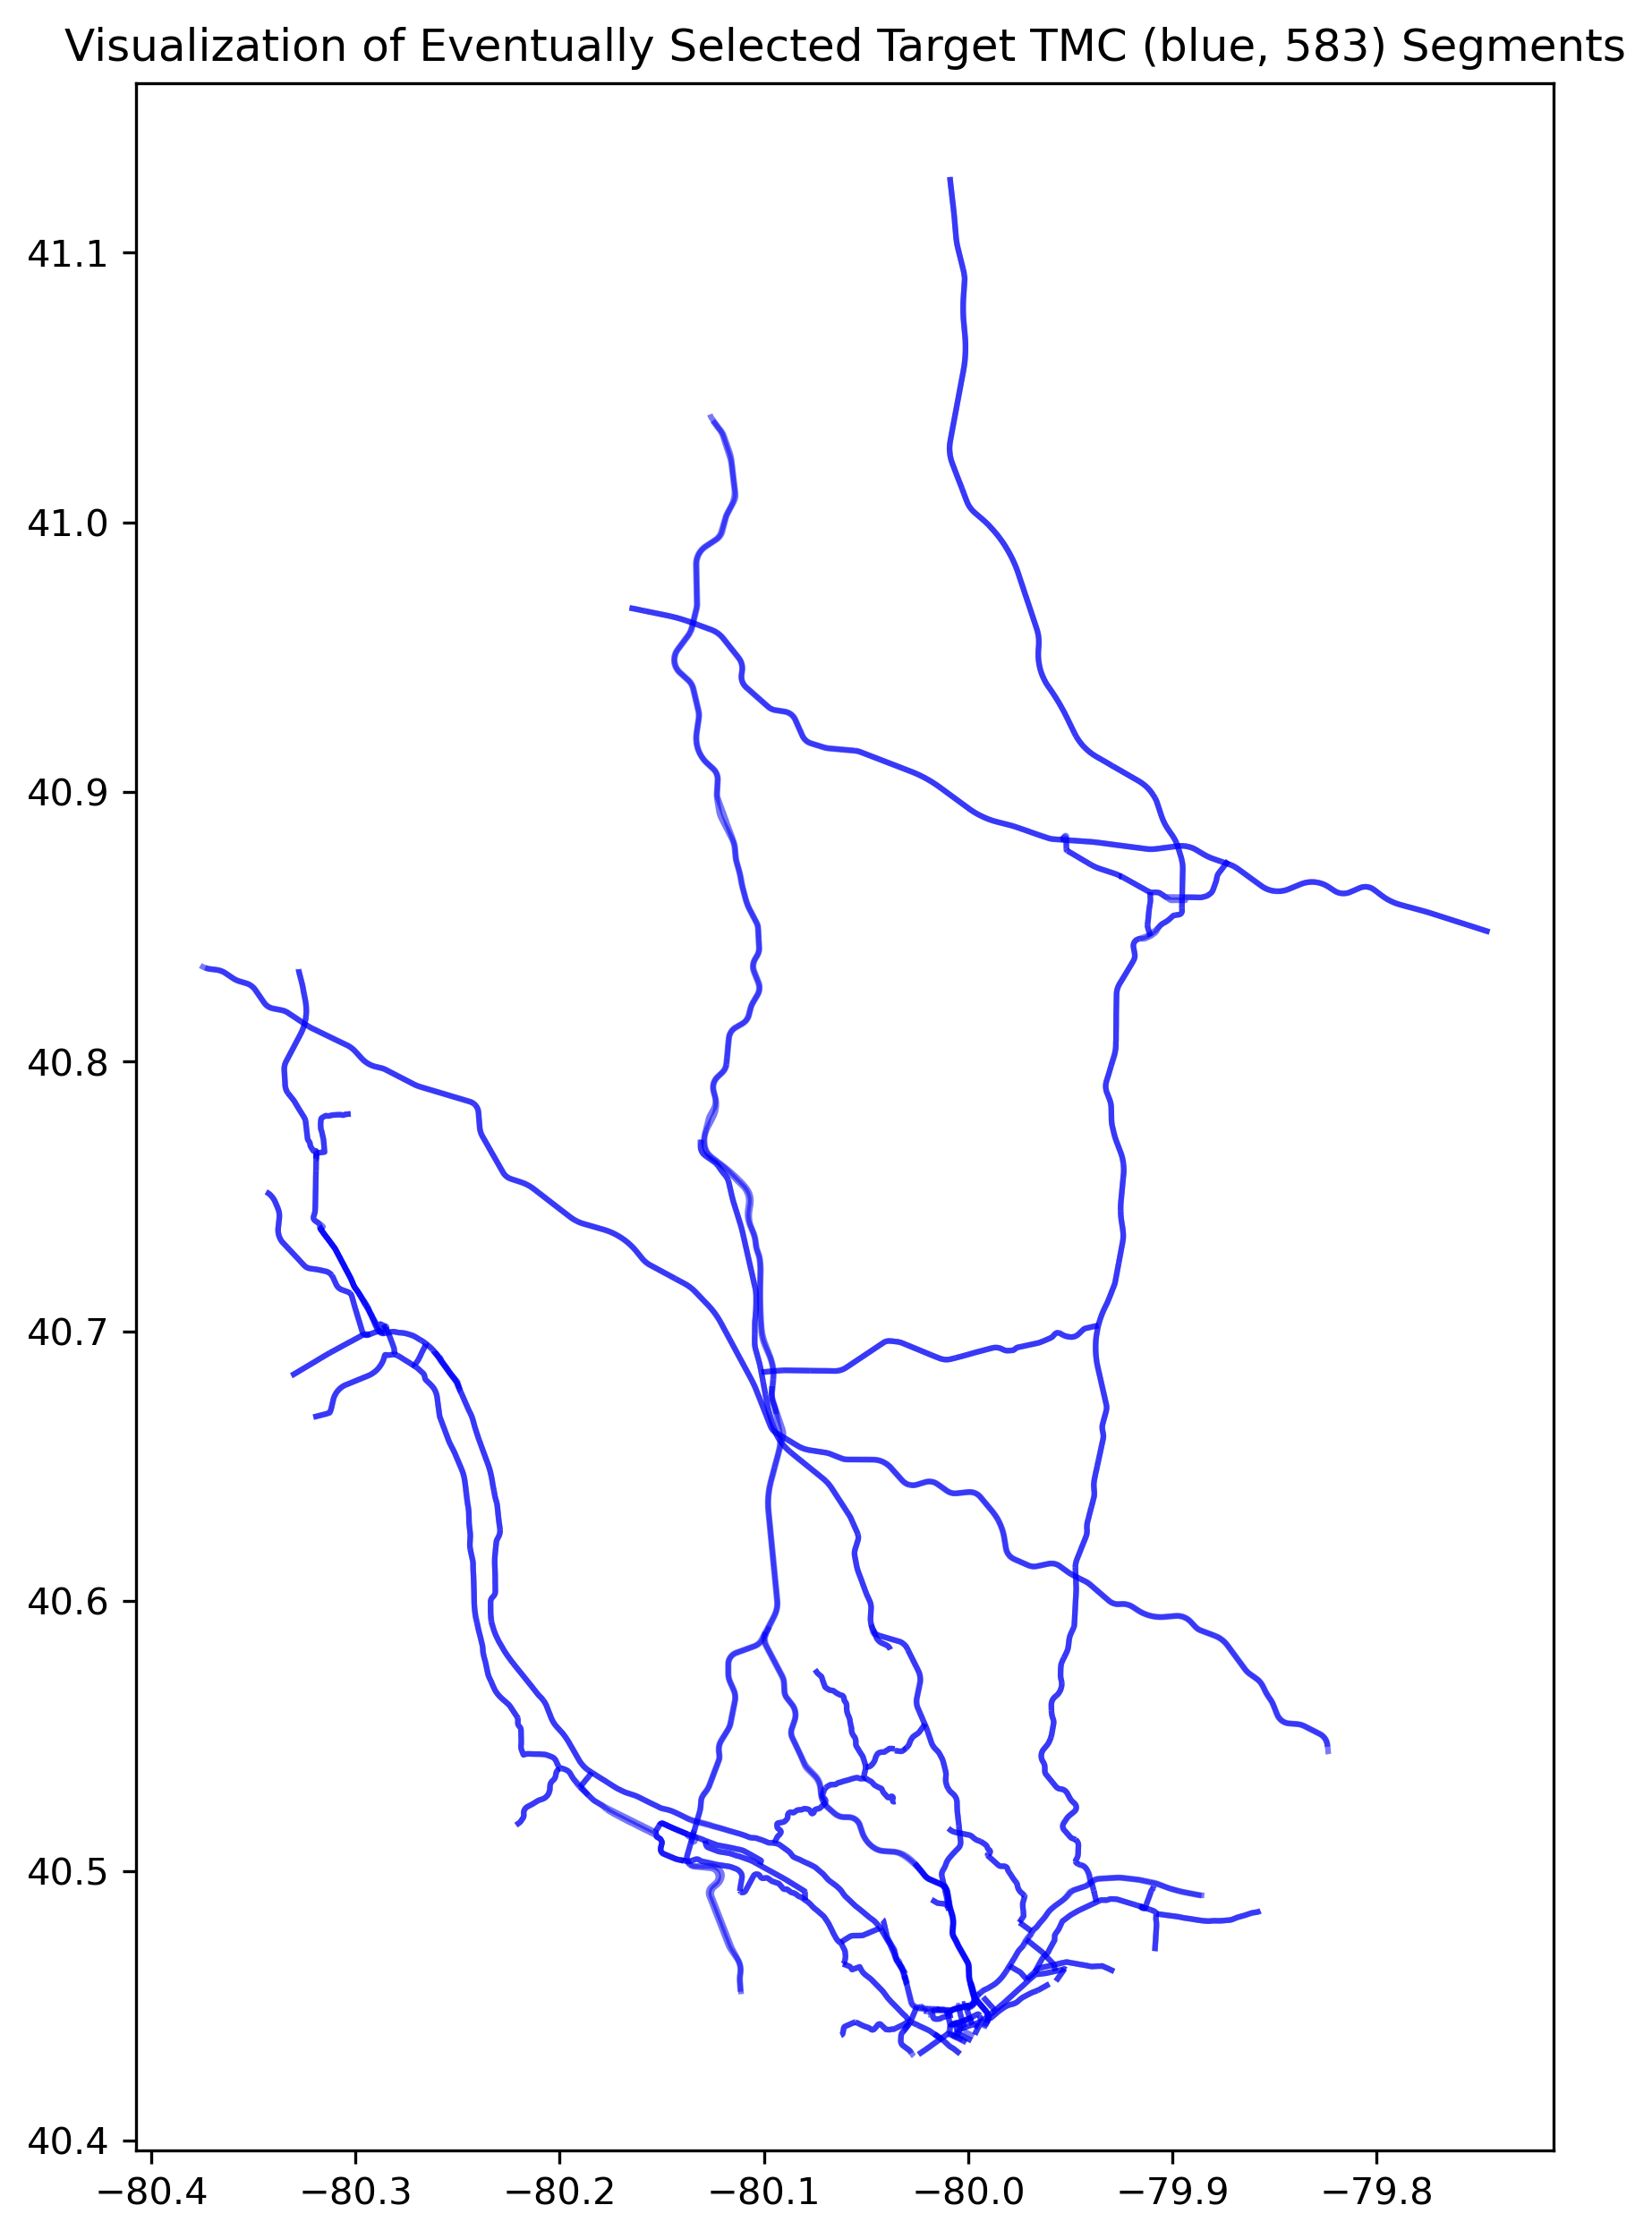

In [96]:
fig, ax = plt.subplots(1,figsize=(15,10), dpi=300)
ax.set_title("Visualization of Eventually Selected Target TMC (blue, 583) Segments")
gdf_tmc_1min.plot(ax=ax, color="grey", alpha=0.1) # TMC segments that at least has one kind of speed data available in TSMO
gdf_tmc[gdf_tmc.id_tmc.isin(set_target_tmc)].plot(ax=ax, color="blue", alpha=0.5)  # 583 finalized TMC target segments, for TSMO

In [97]:
df_spd_tmc_5min_all_selected = df_spd_tmc_5min_all[list_target_tmc]
df_spd_tmc_5min_pv_selected = df_spd_tmc_5min_pv[list_target_tmc]
df_spd_tmc_5min_truck_selected = df_spd_tmc_5min_truck[list_target_tmc]

In [98]:
print(df_spd_tmc_5min_all_selected.shape)
print(df_spd_tmc_5min_pv_selected.shape)

(97092, 1151)
(97092, 1151)


In [99]:
df_spd_tmc_5min_all_selected = df_spd_tmc_5min_all_selected.fillna(method='ffill')  # 755 NaN
df_spd_tmc_5min_pv_selected = df_spd_tmc_5min_pv_selected.fillna(method='ffill')  # 755 NaN
df_spd_tmc_5min_truck_selected = df_spd_tmc_5min_truck_selected.fillna(method='ffill')  # 755 NaN

df_spd_tmc_5min_all_selected = df_spd_tmc_5min_all_selected.fillna(method='bfill')  # 0 NaN
df_spd_tmc_5min_pv_selected = df_spd_tmc_5min_pv_selected.fillna(method='bfill')  # 0 NaN
df_spd_tmc_5min_truck_selected = df_spd_tmc_5min_truck_selected.fillna(method='bfill')  # 0 NaN

C:\Users\haowu\AppData\Local\Temp\ipykernel_820776\1575394639.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spd_tmc_5min_all_selected = df_spd_tmc_5min_all_selected.fillna(method='ffill')  # 755 NaN
C:\Users\haowu\AppData\Local\Temp\ipykernel_820776\1575394639.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spd_tmc_5min_pv_selected = df_spd_tmc_5min_pv_selected.fillna(method='ffill')  # 755 NaN
C:\Users\haowu\AppData\Local\Temp\ipykernel_820776\1575394639.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spd_tmc_5min_truck_selected = df_spd_tmc_5min_truck_selected.fillna(method='ffill')  # 755 NaN
C:\Users\haowu\AppData\Local\Temp\ipykernel_820776\1575394639.py:5: FutureWarning: DataFrame.filln

In [100]:
df_spd_tmc_5min_all_selected

tmc_code,104+08947,104N13494,104P51594,104P13472,104-06171,104-04708,104N06651,104P04525,104-04434,104P04555,...,104+50433,104-04682,104+04527,104N08101,104P09352,104P11614,104N09108,104P06367,104+04518,104-06680
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-01 05:30:00,48.78,32.00,36.00,25.00,49.00,30.19,45.00,58.00,63.00,58.0,...,18.0,17.00,61.00,33.80,29.72,62.80,17.00,47.00,52.00,46.93
2022-02-01 05:35:00,41.00,32.00,40.12,27.00,55.97,30.00,45.39,62.39,61.00,58.0,...,18.0,23.00,67.19,26.00,34.00,61.00,14.85,50.24,52.00,49.40
2022-02-01 05:40:00,46.37,20.99,43.00,27.97,56.90,30.00,46.00,57.00,57.00,58.0,...,18.0,21.39,59.00,26.00,27.00,65.18,12.00,53.00,52.00,46.00
2022-02-01 05:45:00,44.99,17.00,43.00,21.00,61.60,33.00,46.00,65.20,36.00,58.0,...,18.0,24.00,68.00,34.36,27.60,53.00,12.58,53.00,37.00,50.79
2022-02-01 05:50:00,43.00,17.00,43.00,29.38,62.00,30.97,46.59,66.00,63.00,58.0,...,14.8,14.00,74.00,32.00,24.57,68.00,13.00,53.00,34.00,42.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,48.00,25.00,48.00,29.00,49.00,30.00,45.00,60.00,66.00,55.0,...,14.0,21.79,60.00,37.00,36.84,62.16,20.19,31.00,46.00,50.00
2024-01-31 20:40:00,45.00,25.00,48.00,29.00,47.36,30.00,45.00,64.00,71.00,55.0,...,14.0,22.00,70.00,37.00,40.39,64.00,14.56,31.00,45.39,45.00
2024-01-31 20:45:00,44.73,21.00,48.39,29.00,49.00,30.00,45.00,64.00,73.00,55.0,...,14.0,20.10,67.00,37.00,41.00,63.00,15.19,31.00,46.00,41.00


In [ ]:
pickle.dump(df_spd_tmc_5min_all_selected, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_selected.pkl", "wb"))